In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
#hyper-parameters
image_size = 28*28
h_dim = 400
z_dim = 20
batch_size = 128
num_epochs = 20
learning_rate = 1e-3

In [4]:
root = "data/"
train_dataset = datasets.MNIST(root,
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
test_dataset = datasets.MNIST(root,
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              shuffle=False)

In [5]:
from models.vae import VAE

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
print(model)

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=400, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=400, bias=True)
  (fc5): Linear(in_features=400, out_features=784, bias=True)
)


In [6]:
sample_dir = 'samples/vae'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

loss_list = []

for epoch in range(num_epochs):
    for i, (x, _) in enumerate(train_dataloader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        loss_list.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(train_dataloader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

/home/nagailabpbl3/.local/share/virtualenvs/multimodal_generation-otsyb3SM/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/20], Step [10/469], Reconst Loss: 36767.2656, KL Div: 3135.9329
Epoch[1/20], Step [20/469], Reconst Loss: 29528.3340, KL Div: 1106.9414
Epoch[1/20], Step [30/469], Reconst Loss: 27619.1621, KL Div: 1122.6548
Epoch[1/20], Step [40/469], Reconst Loss: 26658.4316, KL Div: 730.9520
Epoch[1/20], Step [50/469], Reconst Loss: 25070.9766, KL Div: 852.6189
Epoch[1/20], Step [60/469], Reconst Loss: 25759.6816, KL Div: 943.8710
Epoch[1/20], Step [70/469], Reconst Loss: 24819.6250, KL Div: 1036.0332
Epoch[1/20], Step [80/469], Reconst Loss: 24287.4414, KL Div: 947.1389
Epoch[1/20], Step [90/469], Reconst Loss: 22360.8008, KL Div: 1240.5615
Epoch[1/20], Step [100/469], Reconst Loss: 21491.9863, KL Div: 1530.0802
Epoch[1/20], Step [110/469], Reconst Loss: 20699.3262, KL Div: 1581.6956
Epoch[1/20], Step [120/469], Reconst Loss: 20087.9551, KL Div: 1698.7827
Epoch[1/20], Step [130/469], Reconst Loss: 19287.4473, KL Div: 1773.2819
Epoch[1/20], Step [140/469], Reconst Loss: 19014.2715, KL Div: 1

In [7]:
loss_list = [x.tolist() for x in loss_list]
loss_list

[70027.234375,
 66659.234375,
 63514.9453125,
 59911.9921875,
 56602.9921875,
 52524.86328125,
 47616.0,
 44238.48828125,
 41470.42578125,
 39903.19921875,
 37945.3359375,
 37832.265625,
 36330.88671875,
 34568.4453125,
 32480.84375,
 30841.654296875,
 31660.64453125,
 30606.39453125,
 30324.83984375,
 30635.275390625,
 30623.421875,
 30690.744140625,
 30282.05078125,
 29202.96484375,
 28763.216796875,
 29240.4375,
 28878.470703125,
 28306.466796875,
 28439.9609375,
 28741.81640625,
 29048.533203125,
 28062.60546875,
 28607.966796875,
 27342.009765625,
 27059.244140625,
 26626.140625,
 27400.69921875,
 27629.4765625,
 27752.4296875,
 27389.3828125,
 28033.212890625,
 28089.787109375,
 26785.3671875,
 27231.0234375,
 27708.623046875,
 27493.775390625,
 26244.7421875,
 28239.572265625,
 27673.240234375,
 25923.595703125,
 26797.7734375,
 26115.0,
 27239.775390625,
 26275.4140625,
 26519.234375,
 26444.666015625,
 26548.71484375,
 25522.63671875,
 27047.0625,
 26703.552734375,
 26127.2832

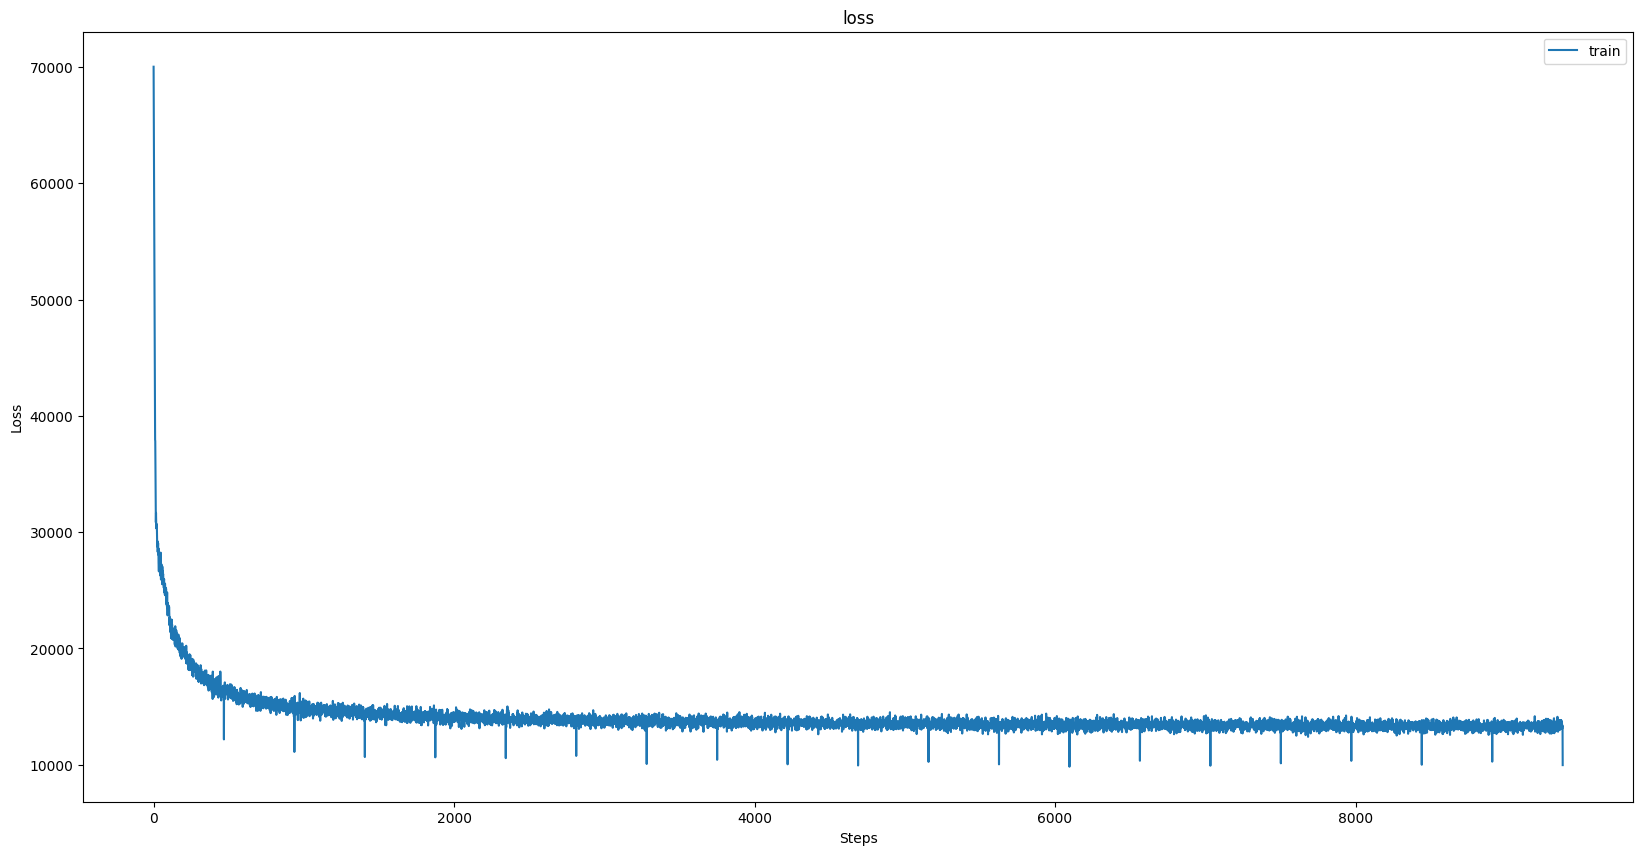

In [8]:
import matplotlib.pyplot as plt

x = list(range(len(loss_list)))

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

ax.set_title("loss")
ax.set_xlabel("Steps")
ax.set_ylabel("Loss")

ax.plot(x, loss_list, label="train")
ax.legend()

plt.show()

In [9]:
import numpy as np

x_tsne = []
y_tsne = []

for img, label in test_dataloader:
    img = img.to(device).view(-1, image_size)
    mu, log_var = model.encode(img)
    z = model.reparameterize(mu, log_var)
    x_tsne.append(z.flatten().tolist())
    y_tsne.append(label.item())
x_tsne = np.array(x_tsne)
y_tsne = np.array(y_tsne)

print(x_tsne.shape)
print(y_tsne.shape)


(10000, 20)
(10000,)


In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(x_tsne)

print(x_tsne)

/home/nagailabpbl3/.local/share/virtualenvs/multimodal_generation-otsyb3SM/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nagailabpbl3/.local/share/virtualenvs/multimodal_generation-otsyb3SM/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[-21.87675   -39.94311  ]
 [ 46.207912  -41.244926 ]
 [  8.666018  -76.39038  ]
 ...
 [-60.06168   -15.428392 ]
 [ 24.960356    1.6922559]
 [ -4.193343   51.893505 ]]


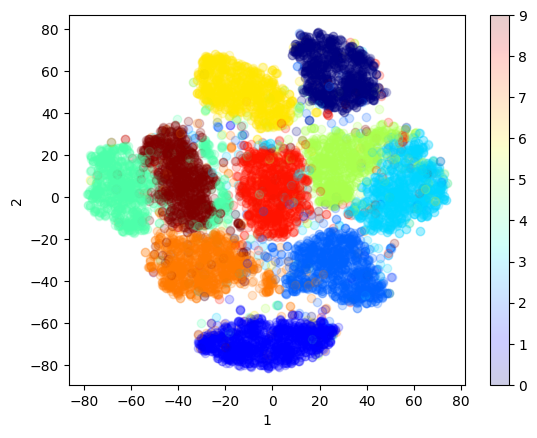

In [11]:
import matplotlib.colors as colors

fig = plt.figure()
ax = fig.add_subplot()

ax.set_xlabel("1")
ax.set_ylabel("2")

for x, y in zip(x_tsne, y_tsne):
    mp = ax.scatter(x[0], x[1],
               alpha=0.2,
               c=y,
               vmin=0,
               vmax=9,
               cmap="jet")

fig.colorbar(mp, ax=ax)

plt.show()